# Preparação do ambiente

## Bibliotecas

In [1]:
import configparser
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import string

from cryptography.fernet import Fernet
from redminelib import Redmine
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tabulate import tabulate
from tqdm.auto import tqdm
from unicodedata import normalize

In [2]:
pd.options.mode.chained_assignment = None

## Constantes e funções auxiliares

In [3]:
NULL_STRING = '#NULLO#'
FILE_CREDS = r'C:/Users/maxwelfreitas/creds.ini'

FILE_SAMPLES = '../datasets/samples_labeling/issues_fiscaliza/20240423/samples.parquet'

FILE_ISSUES = '../datasets/samples_labeling/issues_fiscaliza/20240423/results/issues.parquet'
FILE_ISSUES_REPORT = '../datasets/samples_labeling/issues_fiscaliza/20240423/results/issues_report.xlsx'
FILE_LABELS_RESULTS = '../datasets/samples_labeling/issues_fiscaliza/20240423/results/labels.parquet'

In [4]:
creds = configparser.ConfigParser()
creds.read(FILE_CREDS)

redmine_url = creds['FISCALIZA']['redmine_url']
redmine_api_key = creds['FISCALIZA']['redmine_api_key']

# refkey = creds['ID']['refkey']
# username = creds['ID']['username']
# password = creds['ID']['password']

# refkey = Fernet(refkey)
# username = bytes(username,'utf-8')
# password = bytes(password,'utf-8')

# username = refkey.decrypt(username).decode('utf-8')
# password = refkey.decrypt(password).decode('utf-8')

In [5]:
def parse_issue(issue):
    issue_attrs = ['id', 'tracker', 'status', 'closed_on', 'subject', 'assigned_to']
    issue_results = {}
    for attr in issue_attrs:
        issue_results[attr] = str(issue[attr])

    custom_fields = list(issue.custom_fields.values_list())
    for _, field, value in custom_fields:
        issue_results[field] = str(value)

    return issue_results

In [6]:
def plot_donut(labels,values,title,startangle=30, colors=None):
    fig, ax = plt.subplots(figsize=(5, 3), subplot_kw=dict(aspect="equal"))
    
    wedges, texts = ax.pie(values, wedgeprops=dict(width=0.5), colors=colors, startangle=startangle)
    
    bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")
    
    kw = dict(arrowprops=dict(arrowstyle="-"),bbox=bbox_props,
              zorder=0, va="center")
    
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)

    label_completed = '{:.2f}%'.format(values[0]/values.sum()*100)
    ax.annotate(label_completed,xy=(0,0),horizontalalignment='center', verticalalignment='center')
    
    ax.set_title(title)
    plt.show()

In [7]:
def clean_text(doc, return_tokens=False):

    stop_words = stopwords.words('portuguese')
    stop_words.extend(stopwords.words('english'))
    stop_words.extend(list(string.punctuation))
    
    # stopwords específicas do domínio
    # stop_words.extend(['cm', 'feature', 'features', 'informações', 'itens', 'leve', 'list', 'nulo', 'package', 'pacote', 'pacotes', 'recurso', 'tamanho', 'ver'])
    # remover da lista de stopwords a palavra sem para formar o bigrama "sem fio", relevante para o domínio
    # primeira rodada de classificação demonstrou que não foi uma boa escolha
    # stop_words.remove('sem')
    
    doc = doc.lower()
    doc = normalize('NFKD', doc).encode('ASCII', 'ignore').decode('ASCII')

    tokens = [token for token in word_tokenize(doc, language='portuguese') if token not in stop_words]
    if return_tokens:
        return tokens
    else:
        return ' '.join(tokens)

# Carga e prepação dos dados

## Carga da amostra

In [8]:
df_samples = pd.read_parquet(FILE_SAMPLES)

columns_to_keep = ['marketplace','nome','desc','Título']
df_samples = df_samples[columns_to_keep]

columns_to_keep = ['marketplace','nome','desc','subject']
df_samples.columns = columns_to_keep

df_samples

,marketplace,nome,desc,subject
0,mercadolivre,Streaming Box S Tucson 2018 A 2022 Carplay 4g ...,STREAMING BOX S - 2GB RAM | 32GB ARMAZENAMENTO...,LABEL_PACP_2024_00000001
1,magalu,Smartphone Motorola Moto G52 XT2221-1 Dual Sim...,Fotografia profissional no seu bolsoDescubra i...,LABEL_PACP_2024_00000002
2,mercadolivre,Notebook Dell Latitude 7490 I5 8ª Ger Ddr4 16g...,Os produtos da Dell destacam-se por oferecer s...,LABEL_PACP_2024_00000003
3,amazon,"Mini rede sem fio, placa de rede sem fio USB 3...",,LABEL_PACP_2024_00000004
4,magalu,"Fone Bluetooth TWS Kaidi KD-771 - 5.1, Touch, ...","Fone Bluetooth Tws, Kaidi Kd-771, Bluetooth 5....",LABEL_PACP_2024_00000005
...,...,...,...,...
21511,amazon,CAIXA ACUSTICA PCX6500,,LABEL_PACP_2024_00021512
21512,amazon,Conector de cauda de celular 10 pcs carregando...,"[De alta qualidade] 100% nova fábrica, segura...",LABEL_PACP_2024_00021513
21513,amazon,Avantree Medley Clear - Fones de ouvido sem fi...,,LABEL_PACP_2024_00021514
21514,amazon,"Hilitand Adaptador sem fio, placa de rede sem ...",,LABEL_PACP_2024_00021515


## Carga dos dados extraídos

In [11]:
if os.path.exists(FILE_LABELS_RESULTS):
    
    df_issues = pd.read_parquet(FILE_LABELING_RESULTS)
    df_closed_issues = df_issues[df_issues['status']=='Concluída']
    df_open_issues = df_issues[df_issues['status']!='Concluída']
    
    last_closed = df_issues['closed_on'].max()
    
    map_status = {'Concluída': 'Fechada', 'Responder pesquisa': 'Aberta'}
    df_resumo = df_issues[['id','status']]
    df_resumo['status'] = df_resumo['status'].map(map_status)
    
    df_resumo = df_resumo[['id','status']].groupby('status').count()
    df_resumo.loc['Total'] = df_resumo.sum()
    print(tabulate(df_resumo))
    print(f'Última atualização em: {last_closed} UTC')
else:
    print('Não há dados rotulados')
    df_issues = None


Não há dados rotulados


## Atualização dos dados do Fiscaliza

**Atenção**
Essa operação pode demorar até 10 minutos para ser executada

In [12]:
%%time
redmine = Redmine(redmine_url,key=redmine_api_key)
# redmine = Redmine(redmine_url, username=username, password=password)

# try:
#     # filter issues closed from the last closed_on day in actual dataframe 
#     last_closed_on = df_issues.closed_on.max().strftime('%Y-%m-%d')
#     last_closed_on = f'>={last_closed_on}'
#     closed_issues = redmine.issue.filter(project_id=184, status_id='closed', closed_on=last_closed_on)
# except:
#     pass

# uncomment following line to get all closed issues
# issues = redmine.issue.filter(project_id=184, status_id='closed')

# uncomment following line to get all issues
issues = redmine.issue.filter(project_id=184, status_id='*')

# filter labeling issues
label_issues = [issue for issue in issues if 'LABEL' in issue.subject]
df_label_issues = pd.DataFrame([parse_issue(issue) for issue in label_issues])
df_label_issues['closed_on'] = pd.to_datetime(df_label_issues['closed_on'],errors='coerce')
df_label_issues

CPU times: total: 7.11 s
Wall time: 10min 30s


,id,tracker,status,closed_on,subject,assigned_to,Unidade de Lotação,Título bem elaborado?,Título identifica o produto?,Descrição bem elaborada?,Descrição identifica produto?,É passível homologação?,É transmissor de RF,Qual o tipo do produto?
0,147231,Rotulagem de Dados,Concluída,2024-04-29 18:55:44,LABEL_PACP_2024_00002560,Cesar Alexandre Parazi,FIGF,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Sim,Sim,Roteador/repetidor/reforçador WiFi (2.4GHz/5.8...
1,147230,Rotulagem de Dados,Concluída,2024-04-29 19:01:56,LABEL_PACP_2024_00002559,Cesar Alexandre Parazi,FIGF,1,0,Anúncio não possui descrição,Anúncio não possui descrição,Não,Não,Outro tipo/categoria (não listada acima)
2,147229,Rotulagem de Dados,Concluída,2024-05-06 14:40:28,LABEL_PACP_2024_00002558,Cesar Alexandre Parazi,FIGF,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Não,Não,Outro tipo/categoria (não listada acima)
3,147228,Rotulagem de Dados,Concluída,2024-04-29 19:12:23,LABEL_PACP_2024_00002557,Cesar Alexandre Parazi,FIGF,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Não,Não,Outro tipo/categoria (não listada acima)
4,147227,Rotulagem de Dados,Concluída,2024-05-06 14:42:10,LABEL_PACP_2024_00002556,Cesar Alexandre Parazi,FIGF,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Não,Não,Outro tipo/categoria (não listada acima)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21512,125711,Rotulagem de Dados,Cancelada,2025-04-02 16:45:31,LABEL_PACP_2024_00021508,Maxwel de Souza Freitas,UO021,,,,,,,
21513,125710,Rotulagem de Dados,Cancelada,2025-04-02 16:45:31,LABEL_PACP_2024_00021507,Maxwel de Souza Freitas,UO021,,,,,,,
21514,125709,Rotulagem de Dados,Cancelada,2025-04-02 16:45:30,LABEL_PACP_2024_00021506,Maxwel de Souza Freitas,UO021,,,,,,,
21515,125708,Rotulagem de Dados,Cancelada,2025-04-02 16:45:30,LABEL_PACP_2024_00021505,Maxwel de Souza Freitas,UO021,,,,,,,


In [14]:
# columns_to_keep = [
#     'id', 
#     'tracker', 
#     'status', 
#     'closed_on', 
#     'subject', 
#     'assigned_to', 
#     'Unidade de Lotação', 
#     'Título bem elaborado?', 
#     'Título identifica o produto?', 
#     'Descrição bem elaborada?', 
#     'Descrição identifica produto?', 
#     'É passível homologação?', 
#     'É transmissor de RF', 
#     'Qual o tipo do produto?'
# ]

map_status = {
    'Concluída': 'Fechada', 
    'Responder pesquisa': 'Aberta', 
    'Cancelada': 'Cancelada'
}

df_issues = df_label_issues.sort_values(by='id').reset_index(drop=True)
last_closed = df_issues.closed_on.max()
df_issues.to_parquet(FILE_ISSUES)

df_resumo = df_issues[['id','status']]
df_resumo['status'] = df_resumo['status'].map(map_status)
df_resumo = df_resumo.groupby('status').count()
df_resumo.loc['Total'] = df_resumo.sum()

print('Total de tarefas atualizadas:',len(df_label_issues),'\n')
print(tabulate(df_resumo))
print(f'Última atualização em: {last_closed} UTC')

Total de tarefas atualizadas: 21517 

---------  -----
Cancelada   2508
Fechada    19009
Total      21517
---------  -----
Última atualização em: 2025-04-02 16:45:32 UTC


## Junção dos dados

In [15]:
df_labels = df_samples.merge(df_issues,on='subject', how='left')
columns_to_keep = df_labels.columns[:17]
df_labels = df_labels[columns_to_keep]
df_labels.head()

,marketplace,nome,desc,subject,id,tracker,status,closed_on,assigned_to,Unidade de Lotação,Título bem elaborado?,Título identifica o produto?,Descrição bem elaborada?,Descrição identifica produto?,É passível homologação?,É transmissor de RF,Qual o tipo do produto?
0,mercadolivre,Streaming Box S Tucson 2018 A 2022 Carplay 4g ...,STREAMING BOX S - 2GB RAM | 32GB ARMAZENAMENTO...,LABEL_PACP_2024_00000001,125728,Rotulagem de Dados,Concluída,2024-05-24 19:16:34,Aécio Ramires de Mesquita,UO071,1,1,Sim,Sim,Sim,Sim,TV Box/TV Stick
1,magalu,Smartphone Motorola Moto G52 XT2221-1 Dual Sim...,Fotografia profissional no seu bolsoDescubra i...,LABEL_PACP_2024_00000002,125729,Rotulagem de Dados,Concluída,2024-05-24 19:15:27,Aécio Ramires de Mesquita,UO071,1,1,Sim,Sim,Sim,Sim,Smartphones
2,mercadolivre,Notebook Dell Latitude 7490 I5 8ª Ger Ddr4 16g...,Os produtos da Dell destacam-se por oferecer s...,LABEL_PACP_2024_00000003,125730,Rotulagem de Dados,Concluída,2024-05-24 19:14:41,Aécio Ramires de Mesquita,UO071,1,1,Sim,Sim,Sim,Sim,Computador ou notebook
3,amazon,"Mini rede sem fio, placa de rede sem fio USB 3...",,LABEL_PACP_2024_00000004,125731,Rotulagem de Dados,Concluída,2024-05-24 19:13:34,Aécio Ramires de Mesquita,UO071,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Sim,Sim,Transceptor de radiação restrita (2.4GHz/5.8GHz)
4,magalu,"Fone Bluetooth TWS Kaidi KD-771 - 5.1, Touch, ...","Fone Bluetooth Tws, Kaidi Kd-771, Bluetooth 5....",LABEL_PACP_2024_00000005,125732,Rotulagem de Dados,Concluída,2024-05-24 19:13:01,Aécio Ramires de Mesquita,UO071,1,1,Sim,Sim,Sim,Sim,Transceptor de radiação restrita (2.4GHz/5.8GHz)


# Análise

## Acompanhamento da execução

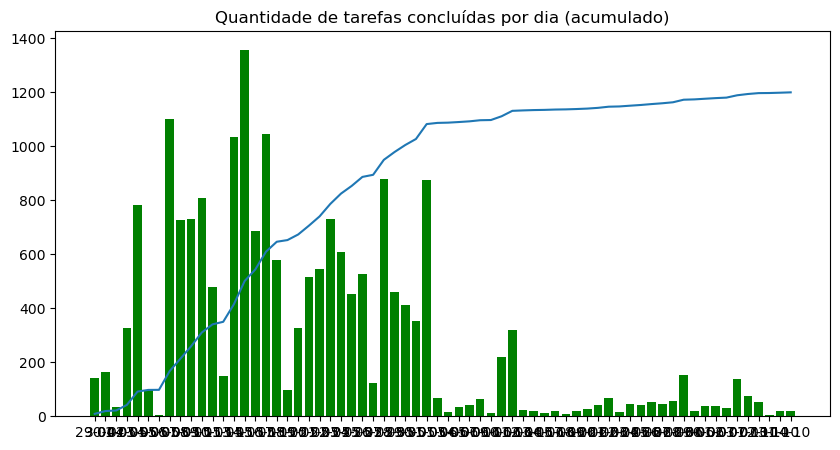

In [16]:
df_closed_on_date = df_labels[df_labels['status']=='Concluída'][['closed_on','id']]
df_closed_on_date['closed_on'] = df_closed_on_date['closed_on'].dt.date
df_closed_on_date = df_closed_on_date.groupby('closed_on',as_index=False).count()
df_closed_on_date['acc'] = df_closed_on_date['id'].cumsum()

date = df_closed_on_date.iloc[:,0].values
date = df_closed_on_date.iloc[:,0].apply(lambda x: x.strftime('%d-%m'))

closed = df_closed_on_date.iloc[:,1].values
closed_acc = df_closed_on_date.iloc[:,2].values

max_acc, _ = df_labels.shape
closed_pct = closed_acc/max_acc * closed.max()


fig,ax = plt.subplots(figsize=(10,5))
ax.plot(date,closed_pct)
ax.bar(date,closed,color='green')
ax.set_title('Quantidade de tarefas concluídas por dia (acumulado)')
plt.show()

In [17]:
df_fiscal = df_labels[df_labels['assigned_to']!='Maxwel de Souza Freitas']
df_fiscal = df_fiscal.pivot_table(index=['assigned_to', 'Unidade de Lotação'],columns='status',values='id',aggfunc='count')
df_fiscal = df_fiscal.fillna(0).astype('int')
df_fiscal['% Conclusão'] = df_fiscal['Concluída']/(df_fiscal.sum(axis=1))*100
df_fiscal['% Conclusão'] = df_fiscal['% Conclusão'].round(1)
df_fiscal = df_fiscal.sort_values(by='% Conclusão',ascending=False)
df_fiscal = df_fiscal.reset_index()

# df_fiscal.columns = ['Fiscal', 'Unidade de Lotação', 'Concluída', 'Aberta', '% Conclusão']
df_fiscal

status,assigned_to,Unidade de Lotação,Cancelada,Concluída,% Conclusão
0,Aécio Ramires de Mesquita,UO071,0,1024,100.0
1,Carlos Juliano Pott,GR05,0,1024,100.0
2,Sebastião Rangel do Nascimento Silva,UO062,0,1024,100.0
3,Romildo Ignácio de Almeida,UO021,0,1024,100.0
4,Rafael Sales Dias,GR04,0,1024,100.0
5,Pedro de Barros,GR07,0,1024,100.0
6,Oppenheimer Herbert Hans Medeiros Queiroz,UO112,0,1024,100.0
7,Marcos Rogerio Gianotto,UO072,0,1024,100.0
8,Marcelo Ricardo Loschi,GR04,0,1024,100.0
9,Williams Roosevelt Monjardim,UO021,0,1024,100.0


In [18]:
df_unidade = df_labels[df_labels['assigned_to']!='Maxwel de Souza Freitas']
df_unidade = df_labels.pivot_table(index='Unidade de Lotação',columns='status',values='id',aggfunc='count')
df_unidade = df_unidade.fillna(0).astype('int')
df_unidade['% Conclusão'] = df_unidade['Concluída']/(df_unidade.sum(axis=1))*100
df_unidade['% Conclusão'] = df_unidade['% Conclusão'].round(1)
df_unidade = df_unidade.sort_values(by='% Conclusão',ascending=False)
df_unidade = df_unidade.reset_index()
df_unidade.columns = ['Unidade', 'Concluída', 'Aberta', '% Conclusão']
df_unidade

,Unidade,Concluída,Aberta,% Conclusão
0,FIGF,0,1024,100.0
1,GR02,0,1024,100.0
2,GR04,0,3072,100.0
3,GR05,0,1024,100.0
4,GR06,0,1024,100.0
5,GR09,0,1024,100.0
6,UO062,0,1024,100.0
7,UO071,0,1024,100.0
8,UO072,0,1024,100.0
9,UO073,0,1024,100.0


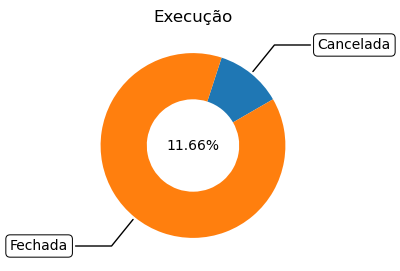

In [19]:
df_count = df_labels[['status','id']].groupby('status').count()
labels = [map_status[label] for label in df_count.index.values]
values = df_count.values.squeeze()
plot_donut(labels,values,'Execução',startangle=30)

In [20]:
with pd.ExcelWriter(FILE_ISSUES_REPORT) as writer:
    df_unidade.to_excel(writer, sheet_name='Unidade', index=False)
    df_fiscal.to_excel(writer, sheet_name='Fiscal', index=False)

## Preenchimento

Verificar se há incoerências no preenchimento, em especial nas perguntas sobre descrição. O campo do Fiscaliza que contém os dados do anúncio é denominado "Descrição" e pode confundir os fiscais durante a rotulagem.



In [21]:
# df_labels['nome_lower'] = df_labels['nome'].str.lower()
# df = df_labels[
#     (df_labels['nome_lower'].str.contains('bluetooth'))
#     &(df_labels['É passível homologação?']=='Não')
# ]

# for id in df.id:
#     print(f'https://sistemas.anatel.gov.br/fiscaliza/issues/{id}')
#     # custom_fields = [{'id': 2159, 'value': 'Não'}]
#     # redmine.issue.update(id,custom_fields=custom_fields)
# df

In [22]:
# df = df_labels[((df_labels['status']=='Concluída')
#                 &(df_labels['É passível homologação?'].isin(['Não é possível afirmar']))
#                 &(df_labels['É transmissor de RF'].isin(['Sim'])))]

# # for id in df.id:
# #     print(f'https://sistemas.anatel.gov.br/fiscaliza/issues/{id}')
# #     # custom_fields = [{'id': 2159, 'value': 'Não'}]
# #     # redmine.issue.update(id,custom_fields=custom_fields)
# df

In [23]:
# df_samples_fiscaliza = pd.read_parquet(FILE_SAMPLES_FISCALIZA)
# columns_to_keep = ['Título','link']
# df = df_samples_fiscaliza[columns_to_keep].merge(df,left_on='Título',right_on='subject')
# # df = df[columns_to_keep]
# for link in df.link:
#     print(link)

In [24]:
# df = df_labels[((df_labels['desc']==' ')
#            &(df_labels['status']=='Concluída')
#            &(df_labels['Descrição bem elaborada?']=='Anúncio não possui descrição')
#            &(df_labels['Descrição identifica produto?'].isin(['Sim','Não'])))]
# for id in df.id:
#     print(f'https://sistemas.anatel.gov.br/fiscaliza/issues/{id}')

In [25]:
# for id in df.id:
#     custom_fields = [{'id': 2157, 'value': 'Anúncio não possui descrição'}, {'id': 2158, 'value': 'Anúncio não possui descrição'}]
#     redmine.issue.update(id,custom_fields=custom_fields)

In [26]:
# df = df_labels[((df_labels['desc']==' ')
#            &(df_labels['status']=='Concluída')
#            &(df_labels['Descrição bem elaborada?'].isin(['Sim','Não']))
#            &(df_labels['Descrição identifica produto?'].isin(['Sim','Não'])))]
# for id in tqdm(df.id):
#     custom_fields = [{'id': 2157, 'value': 'Anúncio não possui descrição'}, {'id': 2158, 'value': 'Anúncio não possui descrição'}]
#     _=redmine.issue.update(id,custom_fields=custom_fields)
# for id in df.id.sample(10):
#     print(f'https://sistemas.anatel.gov.br/fiscaliza/issues/{id}')
# df

In [27]:
# df = df_labels[((df_labels['É passível homologação?']=='Não')
#                 &(df_labels['É transmissor de RF'].isin(['Sim','Não é possível afirmar'])))]
# df

In [28]:
# for id in df.id:
#     print(f'https://sistemas.anatel.gov.br/fiscaliza/issues/{id}')

## Resultados da rotulagem

In [29]:
df_labels.columns

Index(['marketplace', 'nome', 'desc', 'subject', 'id', 'tracker', 'status',
       'closed_on', 'assigned_to', 'Unidade de Lotação',
       'Título bem elaborado?', 'Título identifica o produto?',
       'Descrição bem elaborada?', 'Descrição identifica produto?',
       'É passível homologação?', 'É transmissor de RF',
       'Qual o tipo do produto?'],
      dtype='object')

In [30]:
columns_to_keep = ['id', 'marketplace', 'nome', 'desc', 
                   'Título bem elaborado?', 'Título identifica o produto?',
                   'Descrição bem elaborada?', 'Descrição identifica produto?',
                   'É passível homologação?', 'É transmissor de RF', 'Qual o tipo do produto?']

df_labels_results = df_labels[df_labels['status']=='Concluída'][columns_to_keep]
df_labels_results = df_labels_results.reset_index(drop=True)

map_columns = {'id': 'id', 'nome': 'titulo', 'desc': 'desc', 'marketplace': 'marketplace',
               'Título bem elaborado?': 'titulo_bem_elaborado', 'Título identifica o produto?': 'titulo_identifica_produto',
               'Descrição bem elaborada?': 'desc_bem_elaborada', 'Descrição identifica produto?': 'desc_identifica_produto',
               'É passível homologação?': 'passivel_homologacao', 'É transmissor de RF': 'transmissor_rf', 'Qual o tipo do produto?': 'tipo_produto'}
df_labels_results.columns = df_labels_results.columns.map(map_columns)

map_labels = {'Não': 0, 'Sim': 1, 'Não é possível afirmar': 2, 'Anúncio não possui descrição': 2}

df_labels_results['titulo_bem_elaborado'] = df_labels_results['titulo_bem_elaborado'].astype('int')
df_labels_results['titulo_identifica_produto'] = df_labels_results['titulo_identifica_produto'].astype('int')

df_labels_results['desc_bem_elaborada'] = df_labels_results['desc_bem_elaborada'].map(map_labels)
df_labels_results['desc_identifica_produto'] = df_labels_results['desc_identifica_produto'].map(map_labels)

df_labels_results['passivel_homologacao'] = df_labels_results['passivel_homologacao'].map(map_labels)
df_labels_results['transmissor_rf'] = df_labels_results['transmissor_rf'].map(map_labels)

df_labels_results.to_parquet(FILE_LABELS_RESULTS)

df_labels_results

,id,marketplace,titulo,desc,titulo_bem_elaborado,titulo_identifica_produto,desc_bem_elaborada,desc_identifica_produto,passivel_homologacao,transmissor_rf,tipo_produto
0,125728,mercadolivre,Streaming Box S Tucson 2018 A 2022 Carplay 4g ...,STREAMING BOX S - 2GB RAM | 32GB ARMAZENAMENTO...,1,1,1,1,1,1,TV Box/TV Stick
1,125729,magalu,Smartphone Motorola Moto G52 XT2221-1 Dual Sim...,Fotografia profissional no seu bolsoDescubra i...,1,1,1,1,1,1,Smartphones
2,125730,mercadolivre,Notebook Dell Latitude 7490 I5 8ª Ger Ddr4 16g...,Os produtos da Dell destacam-se por oferecer s...,1,1,1,1,1,1,Computador ou notebook
3,125731,amazon,"Mini rede sem fio, placa de rede sem fio USB 3...",,1,1,2,2,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)
4,125732,magalu,"Fone Bluetooth TWS Kaidi KD-771 - 5.1, Touch, ...","Fone Bluetooth Tws, Kaidi Kd-771, Bluetooth 5....",1,1,1,1,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)
...,...,...,...,...,...,...,...,...,...,...,...
19004,125716,amazon,Conector de cauda de celular 10 pcs carregando...,"[De alta qualidade] 100% nova fábrica, segura...",1,1,1,1,0,0,Outro tipo/categoria (não listada acima)
19005,125717,amazon,Avantree Medley Clear - Fones de ouvido sem fi...,,1,1,2,2,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)
19006,125718,amazon,"Hilitand Adaptador sem fio, placa de rede sem ...",,1,1,2,2,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)
19007,125707,mercadolivre,Drone Vectron Quadricoptero Tamanho G - Polibrinq,VECTRON QUADRICOPTERO TAMANHO G - POLIBRINQ\nO...,1,1,1,1,1,1,Drone


In [31]:
df=df_labels_results.pivot_table(index=['passivel_homologacao'], columns='titulo_identifica_produto',values='id',aggfunc='count')
df['total']=df.sum(axis=1)
df

titulo_identifica_produto,0,1,total
passivel_homologacao,,,
0,564,6903,7467
1,605,9471,10076
2,823,643,1466


In [32]:
# ids = df_items[(df_items['desc_identifica_produto']==2)&(df_items['desc_bem_elaborada']!=2)]['id'].values
# for id in ids:
#     print(f'https://sistemas.anatel.gov.br/fiscaliza/issues/{id}')

In [33]:
df_resumo_tipo = df_labels_results.pivot_table(index='tipo_produto',columns=['passivel_homologacao','transmissor_rf'],values='id',aggfunc='count').fillna(0).astype('int')
df_resumo_tipo['total'] = df_resumo_tipo.sum(axis=1)
df_resumo_tipo = df_resumo_tipo.sort_values(by='total',ascending=False)

df_resumo_tipo

passivel_homologacao                                   0           1        \
transmissor_rf                                         0  1  2     0     1   
tipo_produto                                                                 
Outro tipo/categoria (não listada acima)            6506  0  0   342   874   
Transceptor de radiação restrita (2.4GHz/5.8GHz)       0  1  0    22  3588   
Não é possível afirmar                               504  0  0     2    72   
Carregador para celular (inclusive powerbank)          0  0  0  1092   265   
Smartphones                                            0  0  0    73  1112   
Drone                                                  0  0  0    41   724   
Transceptor de radiofrequência (VHF/UHF)               0  0  0     0   466   
Roteador/repetidor/reforçador WiFi (2.4GHz/5.8GHz)     0  0  0     2   461   
Bateria de lítio para celular                          0  0  0   389    58   
TV Box/TV Stick                                        3  0  0    23   234   
Carregador ou fonte não destinada a celular          234  0  1     0     0   
Bateria não destinada a celular                      143  0  1     0     0   
Computador ou notebook                                 0  0  0    12    85   
Peça ou acessório com fio para computador             74  0  0     0     0   
Modem celular (2G/3G/4G/5G)                            0  0  0     0    42   
Reforçador/repetidor de sinal de celular (2G/3G...     0  0  0     0    41   
Bloqueador de sinal de celular (jammer/FlipperZ...     0  0  0     0     1   

passivel_homologacao                                     2      total  
transmissor_rf                                       2   0    2        
tipo_produto                                                           
Outro tipo/categoria (não listada acima)            35  36  439  8232  
Transceptor de radiação restrita (2.4GHz/5.8GHz)     3   0    0  3614  
Não é possível afirmar                               5  29  941  1553  
Carregador para celular (inclusive powerbank)        9   5    3  1374  
Smartphones                                          0   0    0  1185  
Drone                                                0   0    1   766  
Transceptor de radiofrequência (VHF/UHF)             0   0    0   466  
Roteador/repetidor/reforçador WiFi (2.4GHz/5.8GHz)   0   0    0   463  
Bateria de lítio para celular                        0   0    0   447  
TV Box/TV Stick                                      2   0    0   262  
Carregador ou fonte não destinada a celular          0   1    0   236  
Bateria não destinada a celular                      0   2    6   152  
Computador ou notebook                               1   0    3   101  
Peça ou acessório com fio para computador            0   0    0    74  
Modem celular (2G/3G/4G/5G)                          0   0    0    42  
Reforçador/repetidor de sinal de celular (2G/3G...   0   0    0    41  
Bloqueador de sinal de celular (jammer/FlipperZ...   0   0    0     1

### Títulos

In [34]:
df_labels_results['doc'] = df_labels_results['titulo'].map(clean_text)
df_labels_results['tokens'] = df_labels_results['doc'].apply(lambda doc: doc.split())
df_labels_results

,id,marketplace,titulo,desc,titulo_bem_elaborado,titulo_identifica_produto,desc_bem_elaborada,desc_identifica_produto,passivel_homologacao,transmissor_rf,tipo_produto,doc,tokens
0,125728,mercadolivre,Streaming Box S Tucson 2018 A 2022 Carplay 4g ...,STREAMING BOX S - 2GB RAM | 32GB ARMAZENAMENTO...,1,1,1,1,1,1,TV Box/TV Stick,streaming box tucson 2018 2022 carplay 4g wi-f...,"[streaming, box, tucson, 2018, 2022, carplay, ..."
1,125729,magalu,Smartphone Motorola Moto G52 XT2221-1 Dual Sim...,Fotografia profissional no seu bolsoDescubra i...,1,1,1,1,1,1,Smartphones,smartphone motorola moto g52 xt2221-1 dual sim...,"[smartphone, motorola, moto, g52, xt2221-1, du..."
2,125730,mercadolivre,Notebook Dell Latitude 7490 I5 8ª Ger Ddr4 16g...,Os produtos da Dell destacam-se por oferecer s...,1,1,1,1,1,1,Computador ou notebook,notebook dell latitude 7490 i5 8a ger ddr4 16g...,"[notebook, dell, latitude, 7490, i5, 8a, ger, ..."
3,125731,amazon,"Mini rede sem fio, placa de rede sem fio USB 3...",,1,1,2,2,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),mini rede fio placa rede fio usb 3.0 adaptador...,"[mini, rede, fio, placa, rede, fio, usb, 3.0, ..."
4,125732,magalu,"Fone Bluetooth TWS Kaidi KD-771 - 5.1, Touch, ...","Fone Bluetooth Tws, Kaidi Kd-771, Bluetooth 5....",1,1,1,1,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),fone bluetooth tws kaidi kd-771 5.1 touch prov...,"[fone, bluetooth, tws, kaidi, kd-771, 5.1, tou..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19004,125716,amazon,Conector de cauda de celular 10 pcs carregando...,"[De alta qualidade] 100% nova fábrica, segura...",1,1,1,1,0,0,Outro tipo/categoria (não listada acima),conector cauda celular 10 pcs carregando conec...,"[conector, cauda, celular, 10, pcs, carregando..."
19005,125717,amazon,Avantree Medley Clear - Fones de ouvido sem fi...,,1,1,2,2,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),avantree medley clear fones ouvido fio ouvir t...,"[avantree, medley, clear, fones, ouvido, fio, ..."
19006,125718,amazon,"Hilitand Adaptador sem fio, placa de rede sem ...",,1,1,2,2,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),hilitand adaptador fio placa rede fio adaptado...,"[hilitand, adaptador, fio, placa, rede, fio, a..."
19007,125707,mercadolivre,Drone Vectron Quadricoptero Tamanho G - Polibrinq,VECTRON QUADRICOPTERO TAMANHO G - POLIBRINQ\nO...,1,1,1,1,1,1,Drone,drone vectron quadricoptero tamanho g polibrinq,"[drone, vectron, quadricoptero, tamanho, g, po..."


### Bem elaborados x Mal elaborados

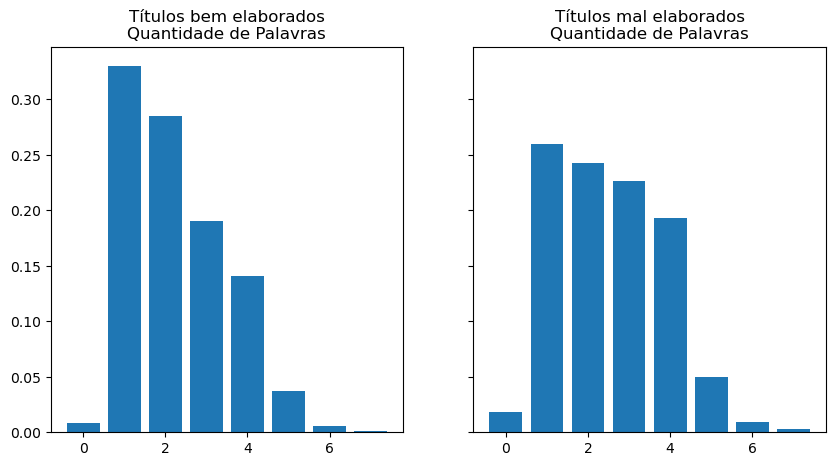

In [35]:
t_bem_elaborados = df_labels_results[df_labels_results['titulo_bem_elaborado']==1]['tokens']
t_mal_elaborados = df_labels_results[df_labels_results['titulo_bem_elaborado']==0]['tokens']

len_t_bem_elaborados = [len(doc) for doc in t_bem_elaborados]
len_t_mal_elaborados = [len(doc) for doc in t_mal_elaborados]

bins = [0,5,10,15,20,25,30,35,50]
h_len_t_bem_elaborados,_ = np.histogram(len_t_bem_elaborados,bins=bins)
h_len_t_mal_elaborados,_ = np.histogram(len_t_mal_elaborados,bins=bins)

h_len_t_bem_elaborados=h_len_t_bem_elaborados/h_len_t_bem_elaborados.sum()
h_len_t_mal_elaborados=h_len_t_mal_elaborados/h_len_t_mal_elaborados.sum()

fig,ax = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
x=range(len(bins)-1)
ax[0].bar(x,h_len_t_bem_elaborados)
ax[0].set_title('Títulos bem elaborados\nQuantidade de Palavras')
ax[1].bar(x,h_len_t_mal_elaborados)
ax[1].set_title('Títulos mal elaborados\nQuantidade de Palavras')

plt.show()

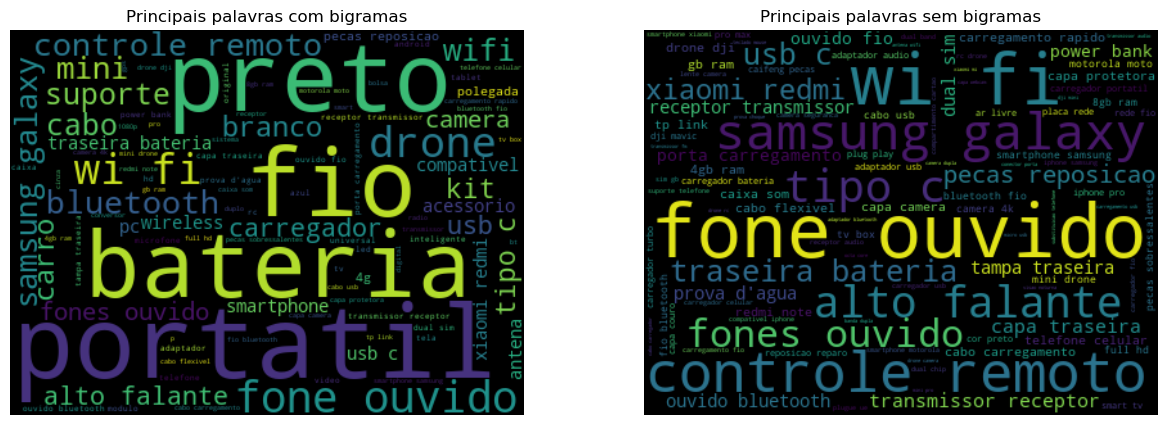

In [36]:
from functions import plot_wordcloud

f_t_bem_elaborados = [token for row in t_bem_elaborados for token in row]
f_t_mal_elaborados = [token for row in t_mal_elaborados for token in row]

plot_wordcloud(f_t_bem_elaborados,100)

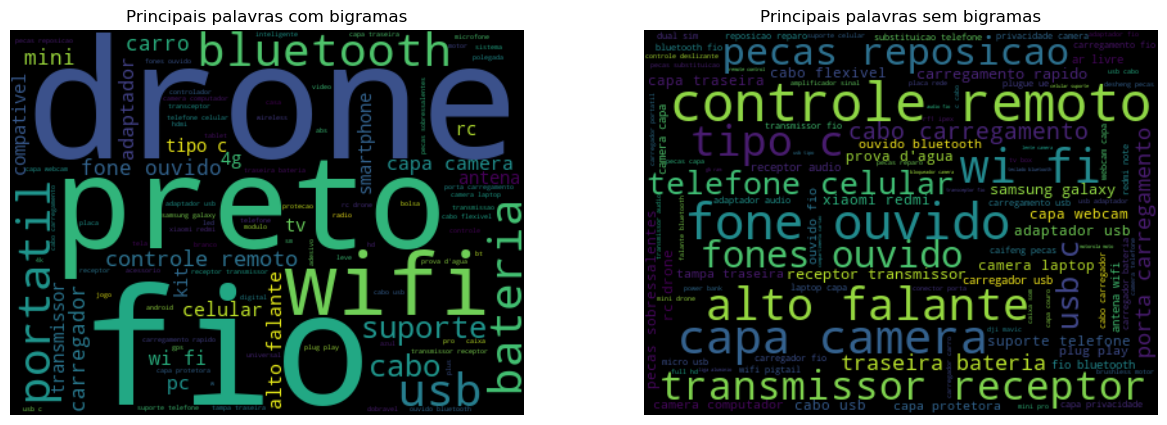

In [37]:
plot_wordcloud(f_t_mal_elaborados,100)

### Produtos passíveis de homologação vs não passíveis

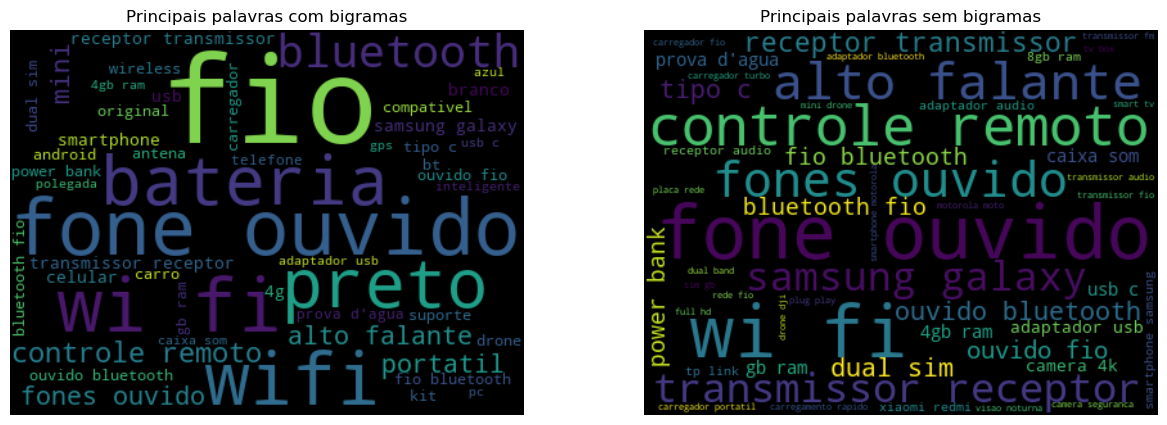

In [38]:
t_passiveis = df_labels_results[df_labels_results['passivel_homologacao']==1]['doc']
t_nao_passiveis = df_labels_results[df_labels_results['passivel_homologacao']==0]['doc']

plot_wordcloud(t_passiveis)

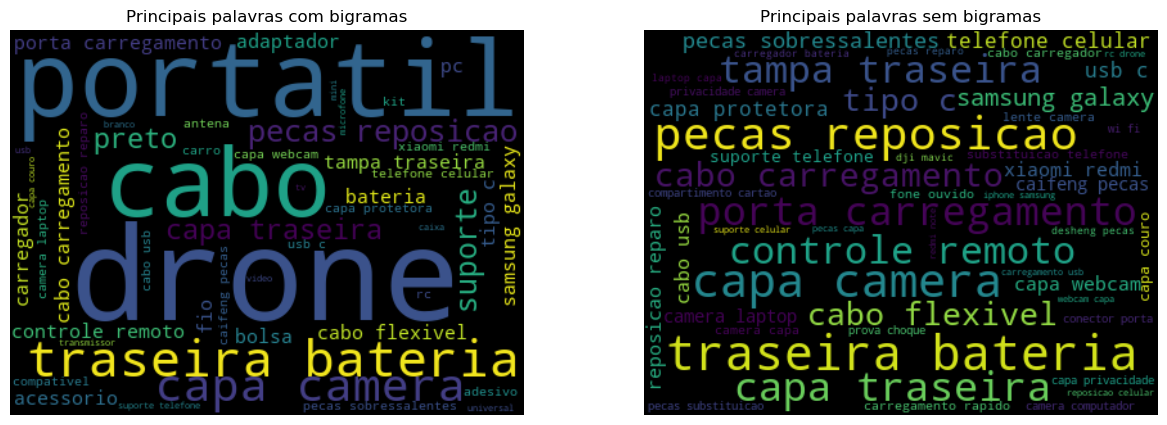

In [39]:
plot_wordcloud(t_nao_passiveis)

### Transmissores de rf vs não transmissores

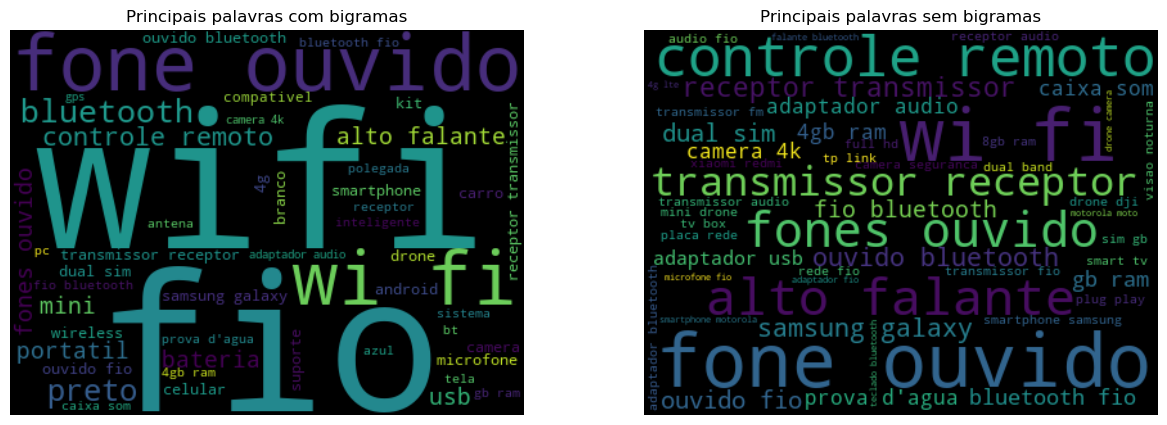

In [40]:
t_transmissor_rf = df_labels_results[df_labels_results['transmissor_rf']==1]['doc']
t_nao_transmissor_rf = df_labels_results[df_labels_results['transmissor_rf']==0]['doc']

plot_wordcloud(t_transmissor_rf)

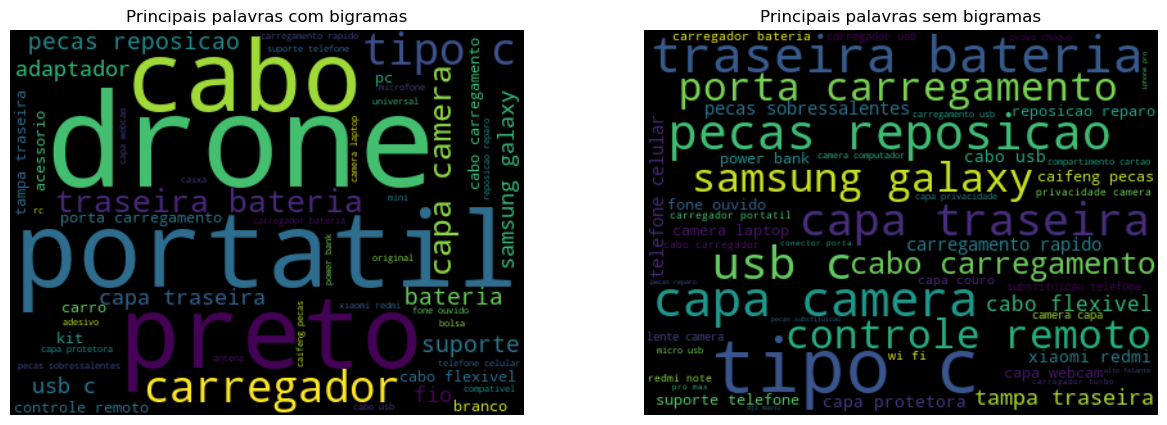

In [41]:
plot_wordcloud(t_nao_transmissor_rf)

# Atualizar Issues

In [42]:
# # redmine = Redmine(redmine_url,key=redmine_api_key)
# redmine = Redmine(redmine_url, username=username, password=password)

# open_issues = redmine.issue.filter(project_id=184, status_id='open')
# len(open_issues)

In [43]:
# for issue in open_issues[:10]:
#     print(issue['id'])

In [44]:
# open_issues = redmine.issue.filter(project_id=184, status_id='open')
# for issue in tqdm(open_issues[11:]):
#     id = issue['id']
#     redmine.issue.update(id,due_date='2024-06-30')

In [45]:
# open_issues = redmine.issue.filter(project_id=184, status_id='open')
# for issue in tqdm(open_issues[11:]):
#     print(issue['id'],issue['due_date'])